# Multivariate Forecasting with DeepAR

This notebook outlines the application of DeepAR , a recently-proposed transformer-based model for time series forecasting, to a Electricity Consumption Dataset. The dataset contains the hourly electricity consumption of 321 customers from 2012 to 2014.

## Package Imports and Global Variables



In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install pytorch-forecasting

In [1]:
import os
import wandb
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


import torch 

import pytorch_lightning as pl
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting.metrics import NormalDistributionLoss
from pytorch_forecasting import TimeSeriesDataSet, Baseline, DeepAR, GroupNormalizer, MultiNormalizer, EncoderNormalizer


In [2]:
warnings.filterwarnings("ignore")
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: images (use `wandb login --relogin` to force relogin)


In [3]:
DATA_PATH = "../datasets/electricity/electricity.csv"

EPOCHS = 1
VAL_PERC = .1 
TEST_PERC = .005
BATCH_SIZE = 32

LAG_TIME = 30
LEAD_TIME = 30

## Data Loading

### Load Electricity Data File

In [4]:
# Load CSV into dataframe and format
df = pd.read_csv(DATA_PATH, index_col=0)
df = df.iloc[:, :-1]
df.index = pd.to_datetime(df.index)
df = df.reset_index().rename({'index':'date'}, axis=1)
df

,date,0,1,2,3,4,5,6,7,8,...,310,311,312,313,314,315,316,317,318,319
0,2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,...,199.0,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0
1,2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,...,265.0,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0
2,2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,...,278.0,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0
3,2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,...,271.0,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0
4,2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,...,267.0,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2019-07-01 21:00:00,11.0,116.0,8.0,844.0,384.0,1590.0,51.0,1412.0,407.0,...,178.0,1897.0,1589.0,166500.0,9917.0,10412.0,324.0,21.0,1870.0,162.0
26300,2019-07-01 22:00:00,11.0,103.0,8.0,749.0,371.0,1366.0,47.0,1265.0,369.0,...,241.0,1374.0,1336.0,158800.0,6812.0,8956.0,302.0,20.0,1506.0,438.0
26301,2019-07-01 23:00:00,12.0,93.0,8.0,650.0,346.0,1282.0,48.0,1079.0,308.0,...,158.0,938.0,1311.0,154300.0,6602.0,5910.0,302.0,18.0,1864.0,621.0
26302,2019-07-02 00:00:00,10.0,92.0,8.0,646.0,349.0,1261.0,48.0,1009.0,288.0,...,120.0,833.0,1227.0,141900.0,6546.0,5502.0,259.0,33.0,2623.0,783.0


### Data Preprocessing
The data is split sequentially into train, validation and test based on `VAL_SIZE` and `TEST_SIZE` global variables. 

In [5]:
n_samples = len(df)
n_val = int(n_samples * VAL_PERC)
n_test = int(n_samples * TEST_PERC)
n_train = n_samples - (n_val + n_test)

# Split data into train and test
train_df = df.iloc[:n_train, :]
val_df = df.iloc[n_train:n_train+n_val]
test_df = df.iloc[n_train+n_val:]

# Rename index to time_idx
train_df = train_df.reset_index().rename({'index':'time_idx'}, axis=1)
val_df = val_df.reset_index().rename({'index':'time_idx'}, axis=1)
test_df = test_df.reset_index().rename({'index':'time_idx'}, axis=1)

train_df['group_ids'] = 0
val_df['group_ids'] = 0
test_df['group_ids'] = 0

In [6]:
# Flatten dataframe into single series 
train_df = train_df.melt(id_vars=['time_idx', 'date'], value_vars=df.columns, var_name='group_ids')
val_df = val_df.melt(id_vars=['time_idx', 'date'], value_vars=df.columns, var_name='group_ids')
test_df = test_df.melt(id_vars=['time_idx', 'date'], value_vars=df.columns, var_name='group_ids')

In [7]:
# Define datasets
train_data = TimeSeriesDataSet(
    train_df,  
    time_idx="time_idx",
    target="value",
    group_ids=['group_ids'],
    min_encoder_length=LAG_TIME,
    max_encoder_length=LAG_TIME,
    min_prediction_length=1,
    max_prediction_length=LEAD_TIME,
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(train_df.group_ids)},
    time_varying_unknown_reals=["value"],
    time_varying_known_reals=["time_idx"],
    target_normalizer=GroupNormalizer(groups=["group_ids"]),
    add_relative_time_idx=False,
    add_target_scales=False,
    randomize_length=None,
)

val_data = TimeSeriesDataSet(
    val_df,  
    time_idx="time_idx",
    target="value",
    group_ids=['group_ids'],
    min_encoder_length=LAG_TIME,
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(val_df.group_ids)},
    time_varying_unknown_reals=["value"],
    time_varying_known_reals=["time_idx"],
    target_normalizer=GroupNormalizer(groups=["group_ids"]),
    add_relative_time_idx=False,
    add_target_scales=False,
    randomize_length=None,
)

test_data = TimeSeriesDataSet(
    test_df,  
    time_idx="time_idx",
    target="value",
    group_ids=['group_ids'],
    min_encoder_length=LAG_TIME,
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(test_df.group_ids)},
    time_varying_unknown_reals=["value"],
    time_varying_known_reals=["time_idx"],
    target_normalizer=GroupNormalizer(groups=["group_ids"]),
    add_relative_time_idx=False,
    add_target_scales=False,
    randomize_length=None,
)

In [ ]:
# Define dataloaders
train_dataloader = train_data.to_dataloader(train=True, batch_size=BATCH_SIZE, num_workers=8)
val_dataloader = val_data.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=8)
test_dataloader = test_data.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=8)

## Model

### DeepAR Overview

<p align="center">
<img width="750" alt="DeepAR" src="https://user-images.githubusercontent.com/34798787/155616570-9903ba06-cc19-46f0-b07f-36a2d53ed021.png">
</p>

DeepAR is an autoregressive recurrent neural network for probalistic time series forecasting. Similar to NBEATS, DeepAR learns a global model from historical data of one or more time series. The same model with shared parameters is used on both the conditioning range (input) as well as the prediction range (output) and consists of mutlti-layer recurrent neural network with LSTM cells. The output of the network is recursively generated one step at a time. We assume the models output distribution consists of product of likelihood factors of each prediction in the output horizon conditioned on the lookback window. The likelihood function is fixed distibution who parameters are given as a function of the network output. We can then obtain samples from the distribution given a set of parameters to compute quantiles of interest over the prediction horizon. Some additional features of DeepAR include:
- **Robust:** Handles time series of different magnitude as well as missing values
- **Flexible:** Allows for covariates that are item dependent, time-dependent or both
- **Interpretable:** Probabilistic forecasts are able to quanity uncertainty

### Training and Validation

In [8]:
# Set random seed 
pl.seed_everything(42)

# Define early stopping criteria
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

# Init pytorch lightning trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    gpus=1,
    gradient_clip_val=0.1,
    # weights_summary="top",
    #callbacks=[early_stop_callback],
    limit_train_batches=.2,
    limit_val_batches=.2,

)

# Init model with structure specified in dataset
net = DeepAR.from_dataset(
    train_data,
    hidden_size=32,
    dropout=0.1,
    loss=NormalDistributionLoss(),
    learning_rate=1e-4,
    log_interval=10,
    log_val_interval=1,
)

# Train and Validate Model
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 13.1 K
4 | distribution_projector | Linear                 | 66    
------------------------------------------------------------------
13.1 K    Trainable params
0         Non-trainable params
13.1 K    Total params
0.052     Total estimated model params size (MB)


Epoch 0:  90%|█████████ | 47085/52226 [34:11<03:44, 22.95it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]
Validating: 0it [00:00, ?it/s]
Validating:   2%|▏         | 108/5142 [00:16<11:06,  7.55it/s]


Validating:   4%|▍         | 217/5142 [00:30<10:08,  8.10it/s]


Validating:   6%|▋         | 326/5142 [00:44<10:24,  7.71it/s]


Epoch 0:  91%|█████████ | 47520/52226 [35:10<03:29, 22.51it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Validating:  11%|█         | 544/5142 [01:12<09:35,  7.99it/s]


Epoch 0:  91%|█████████▏| 47716/52226 [35:47<03:22, 22.22it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  92%|█████████▏| 47789/52226 [35:56<03:20, 22.16it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  92%|█████████▏| 47862/52226 [36:05<03:17, 22.10it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  92%|█████████▏| 47935/52226 [36:15<03:14, 22.04it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  92%|█████████▏| 48008/52226 [36:24<03:11, 21.98it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  92%|█████████▏| 48081/52226 [36:33<03:09, 21.91it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  92%|█████████▏| 48154/52226 [36:43<03:06, 21.86it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  92%|█████████▏| 48227/52226 [36:52<03:03, 21.80it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  92%|█████████▏| 48300/52226 [37:02<03:00, 21.73it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  93%|█████████▎| 48373/52226 [37:12<02:57, 21.67it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  93%|█████████▎| 48446/52226 [37:22<02:54, 21.61it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  93%|█████████▎| 48519/52226 [37:31<02:52, 21.55it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  93%|█████████▎| 48592/52226 [37:40<02:49, 21.49it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  93%|█████████▎| 48665/52226 [37:50<02:46, 21.43it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  93%|█████████▎| 48738/52226 [37:59<02:43, 21.38it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  93%|█████████▎| 48811/52226 [38:09<02:40, 21.32it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  94%|█████████▎| 48884/52226 [38:19<02:37, 21.26it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  94%|█████████▎| 48957/52226 [38:40<02:34, 21.09it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  94%|█████████▍| 49030/52226 [38:50<02:31, 21.04it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  94%|█████████▍| 49103/52226 [38:59<02:28, 20.98it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  94%|█████████▍| 49176/52226 [39:09<02:25, 20.93it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  94%|█████████▍| 49249/52226 [39:19<02:22, 20.87it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  94%|█████████▍| 49322/52226 [39:29<02:19, 20.81it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  95%|█████████▍| 49395/52226 [39:39<02:16, 20.76it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  95%|█████████▍| 49468/52226 [39:48<02:13, 20.71it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  95%|█████████▍| 49541/52226 [39:58<02:09, 20.65it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  95%|█████████▍| 49614/52226 [40:08<02:06, 20.60it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  95%|█████████▌| 49687/52226 [40:17<02:03, 20.55it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  95%|█████████▌| 49760/52226 [40:27<02:00, 20.50it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  95%|█████████▌| 49833/52226 [40:37<01:57, 20.44it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  96%|█████████▌| 49906/52226 [40:47<01:53, 20.39it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  96%|█████████▌| 49979/52226 [40:56<01:50, 20.35it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  96%|█████████▌| 50052/52226 [41:05<01:47, 20.30it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  96%|█████████▌| 50125/52226 [41:15<01:43, 20.25it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  96%|█████████▌| 50198/52226 [41:25<01:40, 20.20it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  96%|█████████▋| 50271/52226 [41:34<01:37, 20.15it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  96%|█████████▋| 50344/52226 [41:44<01:33, 20.10it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  97%|█████████▋| 50417/52226 [41:54<01:30, 20.05it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  97%|█████████▋| 50490/52226 [42:18<01:27, 19.89it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  97%|█████████▋| 50563/52226 [42:27<01:23, 19.85it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  97%|█████████▋| 50636/52226 [42:37<01:20, 19.80it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  97%|█████████▋| 50709/52226 [42:47<01:16, 19.75it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  97%|█████████▋| 50782/52226 [42:57<01:13, 19.71it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  97%|█████████▋| 50855/52226 [43:06<01:09, 19.66it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  98%|█████████▊| 50928/52226 [43:16<01:06, 19.62it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  98%|█████████▊| 51001/52226 [43:25<01:02, 19.57it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  98%|█████████▊| 51074/52226 [43:35<00:58, 19.53it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  98%|█████████▊| 51147/52226 [43:44<00:55, 19.49it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  98%|█████████▊| 51220/52226 [43:54<00:51, 19.44it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  98%|█████████▊| 51293/52226 [44:04<00:48, 19.39it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  98%|█████████▊| 51366/52226 [44:14<00:44, 19.35it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  98%|█████████▊| 51439/52226 [44:23<00:40, 19.31it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  99%|█████████▊| 51512/52226 [44:33<00:37, 19.27it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  99%|█████████▉| 51585/52226 [44:43<00:33, 19.22it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  99%|█████████▉| 51658/52226 [44:53<00:29, 19.18it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  99%|█████████▉| 51731/52226 [45:03<00:25, 19.14it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  99%|█████████▉| 51804/52226 [45:13<00:22, 19.09it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  99%|█████████▉| 51877/52226 [45:23<00:18, 19.05it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0:  99%|█████████▉| 51950/52226 [45:33<00:14, 19.00it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0: 100%|█████████▉| 52023/52226 [45:43<00:10, 18.96it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0: 100%|█████████▉| 52096/52226 [45:54<00:06, 18.91it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0: 100%|█████████▉| 52169/52226 [46:04<00:03, 18.87it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420]


Epoch 0: 100%|██████████| 52226/52226 [46:20<00:00, 18.78it/s, loss=5.66, v_num=6.3e+6, train_loss_step=5.420, val_loss=5.390, train_loss_epoch=5.720]


## Testing

### Visualize Predictions

With the trained model from the previous step, we can apply it to the test set to get an unbias estimate of the models performance. Additionally, we can visualize the results to build some intuition about the forecasts being generated.

In [9]:
# Load best model from checkpoint
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [10]:
# Get predictions from test dataset
preds = best_model.predict(test_dataloader)

# Aggregate inputs, ground truth and classes into tensor alligned with predictions
input_list, true_list, class_list = [], [], []
for x, y in test_dataloader: 
    input_list.append(x["encoder_target"])
    true_list.append(y[0])
    class_list.append(x["groups"])

inputs = torch.cat(input_list)
trues = torch.cat(true_list)
classes = torch.cat(class_list)

print(inputs.shape, preds.shape, trues.shape, classes.shape)

torch.Size([23040, 30]) torch.Size([23040, 30]) torch.Size([23040, 30]) torch.Size([23040, 1])


In [11]:
# Select indices of samples to visualize
n_samples = 10
ss_indices = np.random.choice(range(preds.shape[0]), n_samples, replace=False)
ss_pred = preds[ss_indices]
ss_true = trues[ss_indices]
ss_input = inputs[ss_indices]
ss_class = classes[ss_indices]

print(ss_input.shape, ss_pred.shape, ss_true.shape, ss_class.shape)

torch.Size([10, 30]) torch.Size([10, 30]) torch.Size([10, 30]) torch.Size([10, 1])


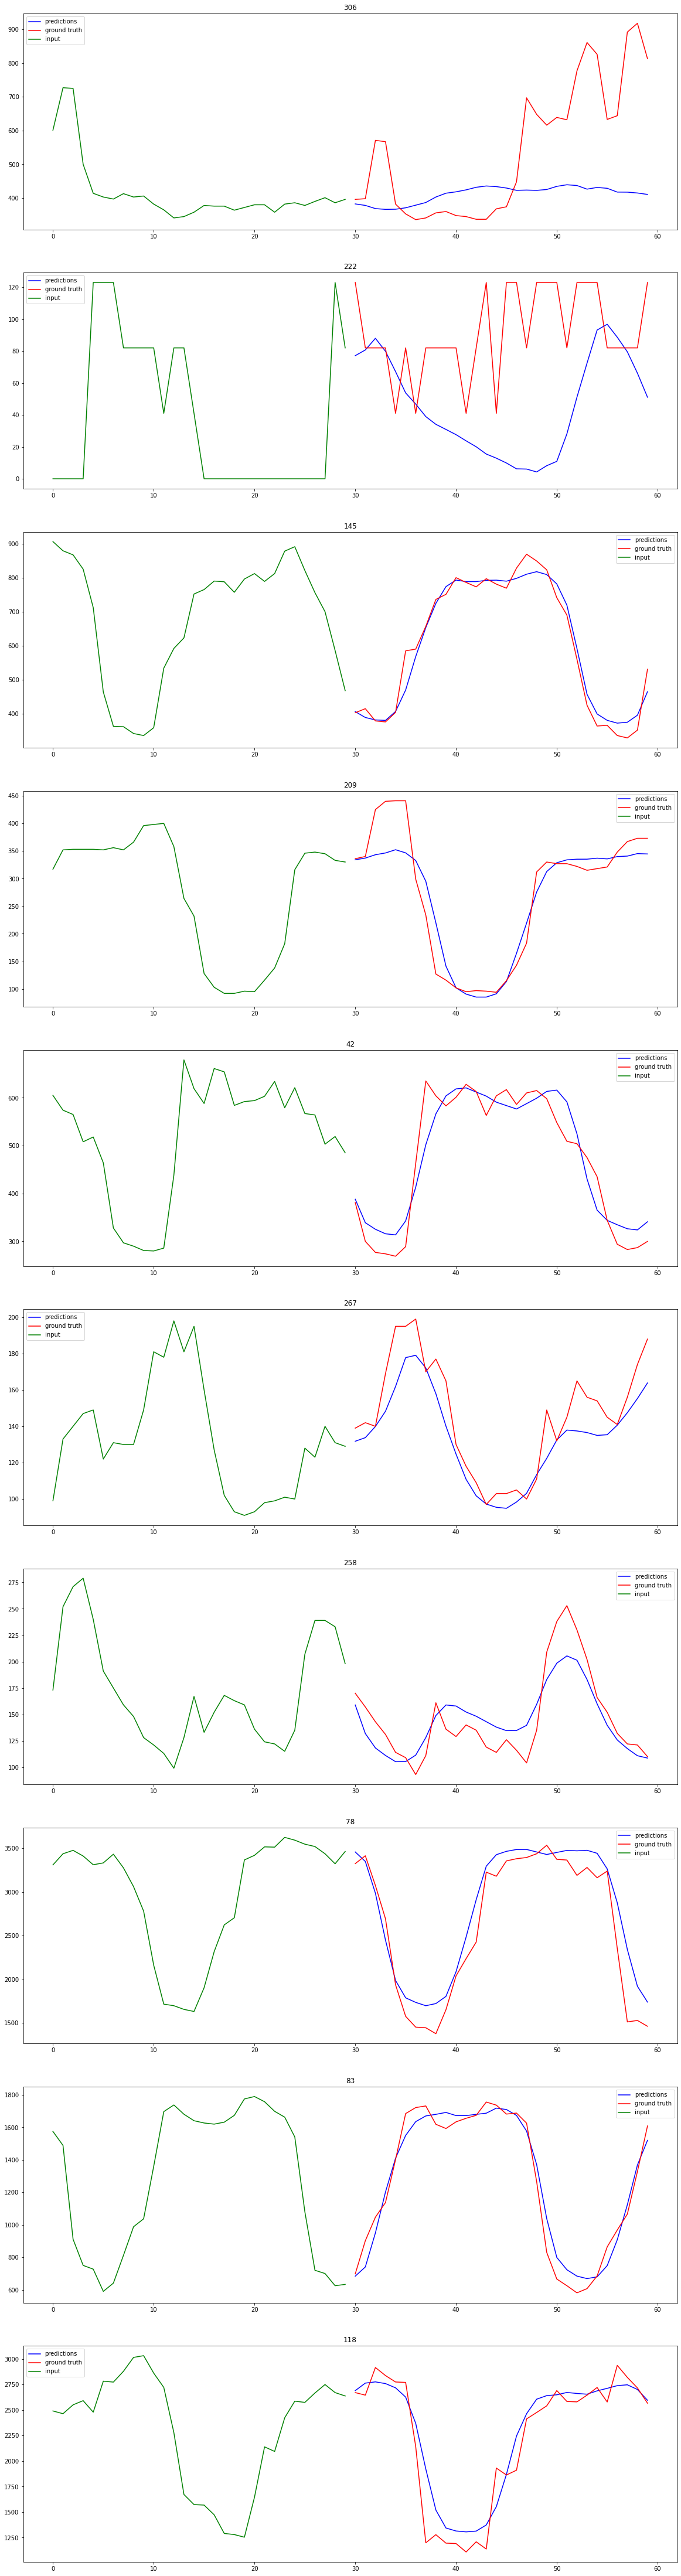

In [13]:
# Loop through samples and plot input, ground truth and prediction
f, axarr = plt.subplots(n_samples, 1, figsize=(20, 80))
for i in range(n_samples):
    series_preds = ss_pred[i, :].squeeze()
    series_trues = ss_true[i, :].squeeze()
    series_inputs = ss_input[i, :].squeeze()

    feat_name = str(ss_class[i].item())
    
    input_len = series_inputs.shape[0]
    pred_gt_len = series_preds.shape[0]
    input_x = np.array([i for i in range(input_len)])
    x = np.array([i for i in range(input_len, input_len+pred_gt_len)])
    axarr[i].plot(x, series_preds, c="blue", label="predictions")
    axarr[i].plot(x, series_trues, c="red", label="ground truth")
    axarr[i].plot(input_x, series_inputs, c="green", label="input")
    axarr[i].legend()
    axarr[i].set_title(feat_name)

### Quantitative Resutls
To assess the performance of DeepAR on the dataset, we calculate its performance on the test set using a set of metrics that are commonly used in time series forecasting. The metrics include Mean Absolute Error (MAE) and Mean Squared Error (MSE). 


In [14]:
# Calculate losses
mse = mean_squared_error(trues.cpu().numpy(), preds.cpu().numpy())
mae = mean_absolute_error(trues.cpu().numpy(), preds.cpu().numpy())

print(f"MSE: {mse} MAE: {mae}")

MSE: 1138711.875 MAE: 205.53628540039062
